# Sentiment Time Series Generation

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
from tqdm import tqdm
import time
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import joblib
import torch

2023-03-06 16:59:42.757679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:59:42.889401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 16:59:42.889423: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-06 16:59:43.620721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 16:59:43.620797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-06 16:59:43.620805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [4]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,1935,"[""Well, I've been waitin' ever since eight"", ""...",pop,1935,"[""Well, he liked waitin' ever minute..."", ""Gue...","['Little girls, listen closely', ""'Cause no on..."
1,6494,"['This kind of love', 'Is more than a lifeline...",pop,6494,"['This to the love', 'Is more we a this', 'For...","[""What you're gonna do"", ""You ain't no friend ..."
2,1720,"['I could tell by the look in her eyes', ""Mayb...",pop,1720,"['I barely can by the fail in her eyes', ""Mayb...","['Swag central', 'See what we have here is', '..."
3,9120,"[""Don't Tell me you love me when I don't"", 'Yo...",pop,9120,"[""Don't call me you love me about this miss"", ...","['Baby if you really love me', 'You had better..."
4,360,"[""Who's the man? who's the boss?"", ""who's the ...",pop,360,"[""Who's the &? why came boss?"", ""who's the<unk...","[""Every day I see your face, I wish that I'd s..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)
df['similar_lyrics'] = df['similar_lyrics'].apply(ast.literal_eval)
df['random_lyrics'] = df['random_lyrics'].apply(ast.literal_eval)

In [7]:
random.choice(df['lyrics'])

['The just are seeking justice',
 'The meek are reaching out',
 'For something only children',
 'Can really know about',
 'And some men cry for mercy',
 "While they deny their brothers' pain",
 'And some men laugh for reasons',
 'They can never quite explain',
 'We are all in this together',
 "And maybe we'll see that one day",
 'When we conquer our fear together',
 'When we finally find a way',
 'And we all need forgiving',
 'For all the damage done',
 'For the things we do, not thinking',
 "For the hurt that we've caused someone",
 'But me, I keep on living',
 'Caught somewhere there between',
 'The reason and the meaning',
 'The vision and the dream',
 'We are all in this together',
 'I know that seems easy to say',
 "But I don't use the word forever",
 "It's enough just to say someday"]

In [8]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"Yo, listen up, I got a story to tell",intro
1,"Gonna take you on a journey, can you feel?",intro
2,"I was born in the ghetto, raised in the streets",verse
3,"Never had much, but I made it with heat",verse
4,"I fought for my dreams, never gave up the fight",verse


In [9]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['Yo, listen up, I got a story to tell',
 'Gonna take you on a journey, can you feel?',
 'I was born in the ghetto, raised in the streets',
 'Never had much, but I made it with heat',
 'I fought for my dreams, never gave up the fight',
 "Now I'm living my best life, shining bright",
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 "I've been through the ups and the downs, the twists and the turns",
 'But I always keep my head up, never letting my fire burn',
 "I've got the power, got the drive, never gonna stop",
 'Gonna make my mark, till the beat drops',
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 'So listen up, hear what I say',
 "I'm the king of the game, leading the way",
 "With my rhymes, and my flows, I'm unstoppable",
 "Gonna take the wo

## Sentiment

In [10]:
#sent_pipeline = pipeline(model='distilbert-base-uncased-finetuned-sst-2-english')
sent_pipeline = pipeline(model='siebert/sentiment-roberta-large-english')

In [11]:
sentences = ['I love you', 'I hate you', 'I am going to the store to buy some milk.']

model_output = sent_pipeline(sentences)
model_output

[{'label': 'POSITIVE', 'score': 0.998561680316925},
 {'label': 'NEGATIVE', 'score': 0.9991401433944702},
 {'label': 'POSITIVE', 'score': 0.9908149838447571}]

In [12]:
def get_unique_sentiment(sentiment_output):
    # Map sentiment in a unique value ranging [-1,1]
    unique_sentiments = []
    for so in sentiment_output:
        if so['label'] == 'POSITIVE':
            pos = so['score']
            neg = 1 - pos
        else:
            neg = so['score']
            pos = 1- neg
        unique_sentiments.append(pos - neg)
    return unique_sentiments

In [13]:
unique_scores = get_unique_sentiment(model_output)
list(zip(sentences, unique_scores))

[('I love you', 0.9971233606338501),
 ('I hate you', -0.9982802867889404),
 ('I am going to the store to buy some milk.', 0.9816299676895142)]

In [14]:
eg_sentibert_ts = get_unique_sentiment(sent_pipeline(eg_lyrics))

In [15]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

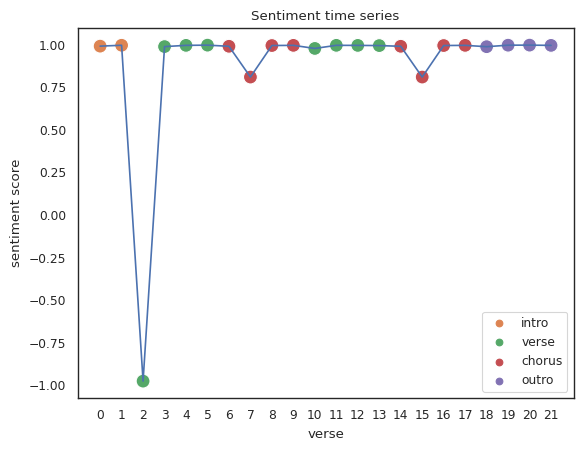

In [16]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentibert_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentibert_ts, 
                     x = range(len(eg_sentibert_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentibert_ts)))
ax.set_xlabel('verse')
ax.set_ylabel('sentiment score')
ax.set_title('Sentiment time series')
tikzplotlib.save('../tikz/sentibert_ts.tex')

In [17]:
sentibert_ts = [get_unique_sentiment(sent_pipeline(lyrics)) for lyrics in tqdm(df['lyrics'][:10])]

  0%|                                                                             | 0/10 [00:00<?, ?it/s]

 10%|██████▉                                                              | 1/10 [00:08<01:18,  8.76s/it]

 20%|█████████████▊                                                       | 2/10 [00:31<02:14, 16.87s/it]

 30%|████████████████████▋                                                | 3/10 [00:45<01:48, 15.43s/it]

 40%|███████████████████████████▌                                         | 4/10 [01:10<01:55, 19.29s/it]

 50%|██████████████████████████████████▌                                  | 5/10 [01:31<01:40, 20.08s/it]

 60%|█████████████████████████████████████████▍                           | 6/10 [01:40<01:04, 16.19s/it]

 70%|████████████████████████████████████████████████▎                    | 7/10 [01:48<00:40, 13.40s/it]

 80%|███████████████████████████████████████████████████████▏             | 8/10 [02:01<00:26, 13.34s/it]

 90%|██████████████████████████████████████████████████████████████       | 9/10 [02:19<00:14, 14.84s/it]

100%|████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 16.30s/it]

100%|████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.89s/it]

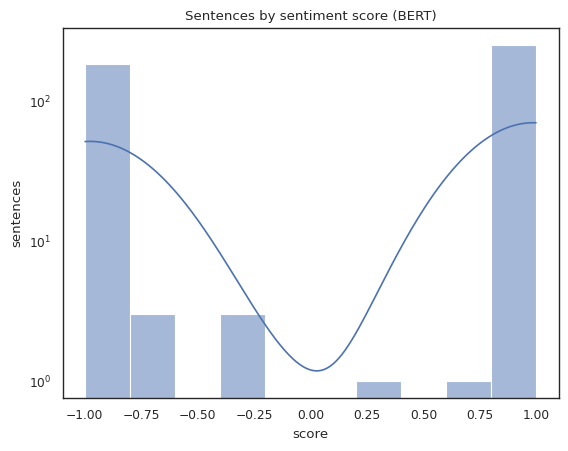

In [18]:
bert_scores = [score for sb_ts in sentibert_ts for score in sb_ts]

fig, ax = plt.subplots()
ax = sns.histplot(bert_scores, kde=True)
ax.set_xlabel('score')
ax.set_ylabel('sentences')
ax.set_yscale('log')
ax.set_title('Sentences by sentiment score (BERT)')
tikzplotlib.save('../tikz/hist_sentibert.tex')

In [19]:
# VADER model
sid = SentimentIntensityAnalyzer()

for sentence in sentences:
    print(sentence, sid.polarity_scores(sentence)['compound'])

I love you 0.6369
I hate you -0.5719
I am going to the store to buy some milk. 0.0


In [20]:
def generate_vader_ts(lyrics):
    return [sid.polarity_scores(verse)['compound'] for verse in lyrics]

In [21]:
eg_sentivader_ts = generate_vader_ts(eg_lyrics)

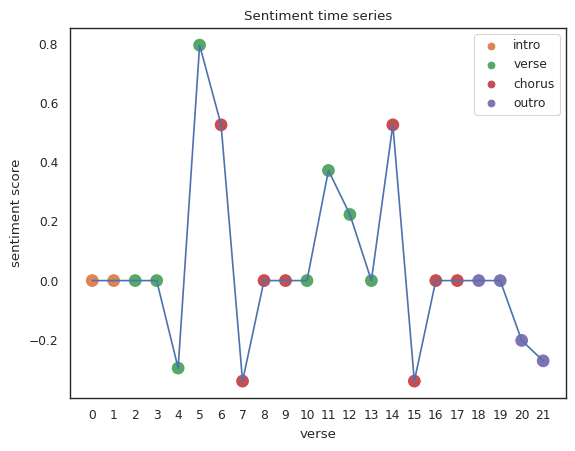

In [22]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentivader_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentivader_ts, 
                     x = range(len(eg_sentivader_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentivader_ts)))
ax.set_xlabel('verse')
ax.set_ylabel('sentiment score')
ax.set_title('Sentiment time series')
tikzplotlib.save('../tikz/sentivader_ts.tex')

In [23]:
vader_sen_ts = [generate_vader_ts(lyrics) for lyrics in tqdm(df['lyrics'][:10])]

  0%|                                                                             | 0/10 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 301.83it/s]

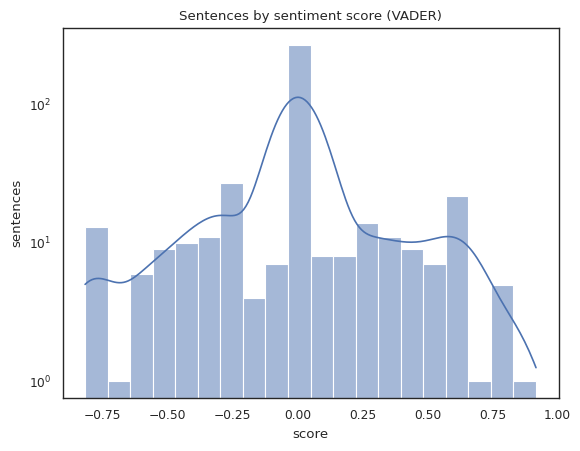

In [24]:
vader_scores = [score for vst in vader_sen_ts for score in vst]

fig, ax = plt.subplots()
ax = sns.histplot(vader_scores, kde=True, bins=20)
ax.set_xlabel('score')
ax.set_ylabel('sentences')
ax.set_title('Sentences by sentiment score (VADER)')
ax.set_yscale('log')
tikzplotlib.save('../tikz/hist_sentivader.tex')

In [25]:
corr = np.corrcoef(vader_scores, bert_scores)[0, 1]

print(f'Correlation VADER and BERT sentiment scores: {corr}')

Correlation VADER and BERT sentiment scores: 0.25540352501886077


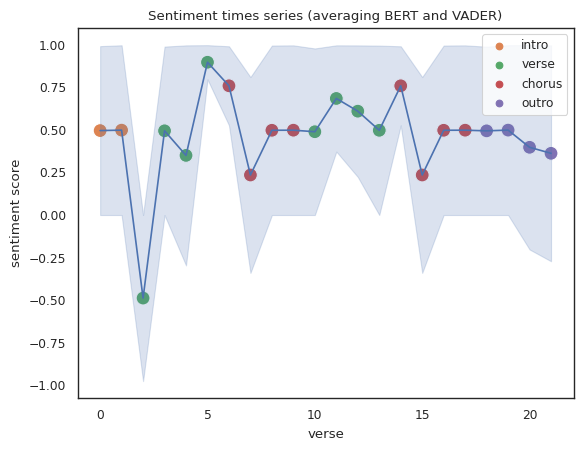

In [26]:
fig, ax = plt.subplots()
# Compute mean for basic scatteplot
eg_sent_ts = np.mean(np.column_stack((eg_sentibert_ts, eg_sentivader_ts)), axis=1)
ax = sns.scatterplot(y = eg_sent_ts, 
                     x = range(len(eg_sent_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
# Create a DataFrame for lineplot
data = {'sentiment': eg_sentibert_ts + eg_sentivader_ts,
        'model': ['bert'] * len(eg_sentibert_ts) + ['vader'] * len(eg_sentivader_ts),
        'timestamp': list(range(0,len(eg_sentibert_ts))) + list(range(0,len(eg_sentivader_ts)))}
eg_sent_ts = pd.DataFrame(data)
ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment')
ax.set_xlabel('verse')
ax.set_ylabel('sentiment score')
ax.set_title('Sentiment times series (averaging BERT and VADER)')
tikzplotlib.save('../tikz/sentiment_ts.tex')

In [27]:
ts_data = {'sentivader': {}, 'sentibert': {}, 'sentiment': {}}



sentibert_execution_times = []
sentivader_execution_times = []

for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:        
    # Initialize lists in dict
    for td in ts_data:        
        ts_data[td][lyrics_type] = []    
    for lyr in df[lyrics_type]:
        # Generate sentibert ts for the current ts type
        start_time = time.time()
        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr))
        end_time = time.time()  
        execution_time = end_time - start_time
        sentibert_execution_times.append(execution_time)
        ts_data['sentibert'][lyrics_type].append(sentibert_ts)
        # Generate sentivader ts for the current ts type
        start_time = time.time()
        sentivader_ts = generate_vader_ts(lyr)
        end_time = time.time()
        execution_time = end_time - start_time
        sentivader_execution_times.append(execution_time)
        ts_data['sentivader'][lyrics_type].append(sentivader_ts)
        # Avg the 2 time series for the current ts type
        sentiment_ts = list(np.mean(np.column_stack((
            sentibert_ts, sentivader_ts)), axis=1))                        
        ts_data['sentiment'][lyrics_type].append(sentiment_ts)
        
for td in ts_data:
    data = pd.DataFrame(ts_data[td])
    filename = f'../data/evaluation/time-series/{td}_ts.csv'
    data.to_csv(filename, index=False)

In [28]:
np.mean(sentibert_execution_times)

23.777844774987962

In [29]:
np.std(sentibert_execution_times)

13.855625171866693

In [30]:
np.mean(sentivader_execution_times)

0.005889672173394097

In [31]:
np.std(sentivader_execution_times)

0.004323952153288141

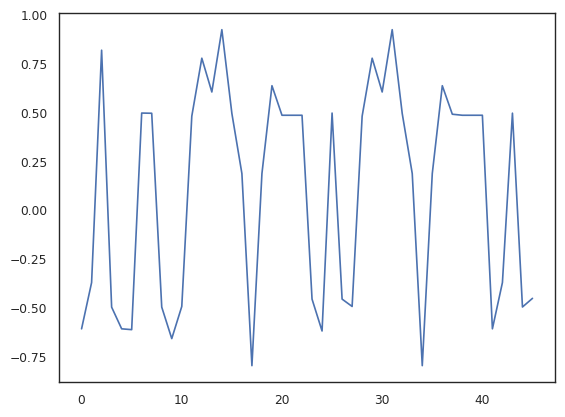

In [32]:
plt.plot(random.choice(ts_data['sentiment']['lyrics']))

## Emotion

In [33]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [34]:
def get_logits(sentence, tokenizer, model, to_numpy=False):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    if to_numpy:
        return logits[0].numpy()
    else:
        return logits

In [35]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [36]:
sentences = ["I am so happy right now!",            
            "What a beautiful surprise!.",
            "This news made me feel so worried.",
            "I am so excited for my vacation!",
            "I am feeling really calm and content.",
            "That smell is making me feel so disgusted.",
            "I am going to the store to buy some milk"]

In [37]:
logits_tensor = [get_logits(sentence, tokenizer=tokenizer, model=model) for sentence in sentences]
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [38]:
labels

['joy', 'joy', 'fear', 'joy', 'joy', 'disgust', 'neutral']

In [39]:
eg_multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, model=model, to_numpy=True) for verse in eg_lyrics])

In [40]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in eg_lyrics]
labels = [logits2label(lt, model=model) for lt in logits_tensor]

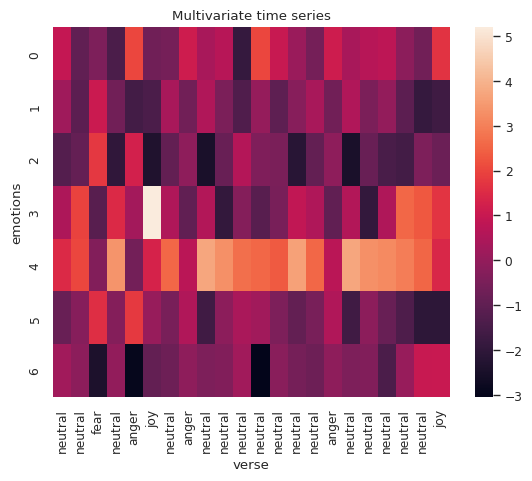

In [41]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('verse')
ax.set_ylabel('emotions')
ax.set_title('Multivariate time series')
ax.set_xticklabels(labels, rotation=90)
tikzplotlib.save('../tikz/emotion_multi_ts.tex')

In [42]:
global_scaler = joblib.load('../models/gpca/emo_scaler.pkl')
global_pca = joblib.load('../models/gpca/emo_pca.pkl')

In [43]:
pca_output = global_pca.transform(global_scaler.transform(eg_multi_ts))

eg_uni_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

In [44]:
color_map = {}
for idx, label in enumerate(list(dict.fromkeys(labels))):    
    # Map color excluding first color of the palette 
    color_map[label] = sns.color_palette()[idx+1]

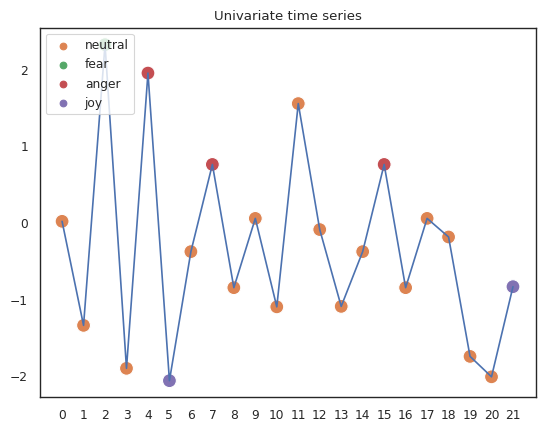

In [45]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax =  sns.scatterplot(y = eg_uni_ts,
                      x = range(len(eg_uni_ts)),
                      hue=labels, s=100,
                      palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/emotion_uni_ts_gpca.tex')


In [46]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    ts_data[lyrics_type] = []
    for lyr in df[lyrics_type]:
        multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, 
                             model=model, to_numpy=True) for verse in lyr])
        scl_multi_ts = global_scaler.transform(multi_ts)
        pca_output = global_pca.transform(scl_multi_ts)
        emotion_ts = list(
            map(lambda unique_element: unique_element[0], pca_output))        
        ts_data[lyrics_type].append(emotion_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/emotion_ts.csv'
ts_data.to_csv(filename, index=False)

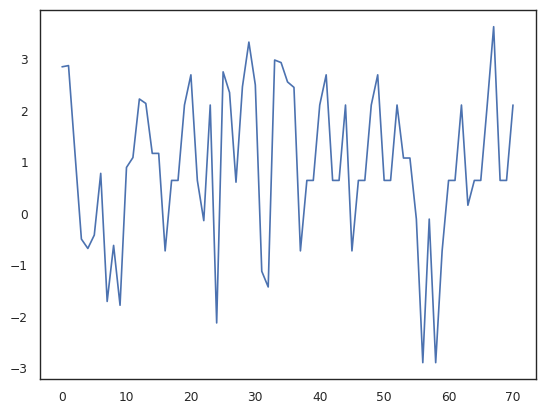

In [47]:
plt.plot(random.choice(ts_data['lyrics']))